# Mask R-CNN - Inspect Fish Trained Model

Code and visualizations to test, debug and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR) # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import fishvsall

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


# Configurations

In [11]:
config = fishvsall.FishConfig()
FISH_DIR = "/media/ernesto/Seagate Backup Plus Drive/Dataset_Thesis/Dia/Video_sin_reflejo"
FISH_DIR 

'/media/ernesto/Seagate Backup Plus Drive/Dataset_Thesis/Dia/Video_sin_reflejo'

In [12]:
# Override the training configurations with a few changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE=0.95
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

# Notebook preferences

In [13]:
# Device to load the neural network on.
# Useful if you're training a model on the same machine, 
#in which case use CPU and leave the GPU for training.
DEVICE = "/cpu:0" #/cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or ' training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = 'inference'

In [14]:
def get_ax(rows = 1, cols = 1, size = 16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a 
    central point to control graph sizes.
    
    Adjust the size attribute to control how big render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Load Test Dataset

In [15]:
# Load validation dataset
dataset = fishvsall.FishDataset()
dataset.load_fish(FISH_DIR, "test")

#Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 30
Classes: ['BG', 'fish']


# Load Model

In [16]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode = "inference", model_dir = MODEL_DIR, config = config)

W0218 14:00:13.659519 140584217757504 deprecation_wrapper.py:119] From /home/ernesto/PycharmProjects/MaskRCNNMatterport/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0218 14:00:13.722391 140584217757504 deprecation_wrapper.py:119] From /home/ernesto/PycharmProjects/MaskRCNNMatterport/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0218 14:00:13.773059 140584217757504 deprecation_wrapper.py:119] From /home/ernesto/PycharmProjects/MaskRCNNMatterport/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0218 14:00:13.859849 140584217757504 deprecation_wrapper.py:119] From /home/ernesto/PycharmProjects/MaskRCNNMatterport/venv/lib/python3.6/site-packages/ke

In [23]:
# Set path to fish weights file

weights_path = "/media/ernesto/Seagate Backup Plus Drive/ProgramasUtiles/MaskRCNN/Mask_RCNN/logs/fish20200122T1342/mask_rcnn_fish_0075.h5"

# Or, load the last model you trained
# weights_path = model.find_last()

#Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name = True)

Loading weights  /media/ernesto/Seagate Backup Plus Drive/ProgramasUtiles/MaskRCNN/Mask_RCNN/logs/fish20200122T1342/mask_rcnn_fish_0075.h5
Re-starting from epoch 75


In [24]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    PR = []
    RE = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        #results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        results = model.detect([image], verbose = 0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap, precision , recall = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'], iou_thresholds=np.array([0.5]),
            verbose=0)
        APs.append(ap)
        PR.append(precision)
        RE.append(recall)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}    P: {:.2f}   R: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap, precision, recall))
    return APs, PR, RE

# Run on validation set
#limit=50
image_ids=dataset.image_ids
#np.random.shuffle(image_ids)
APs, PR, RE = compute_batch_ap(dataset, image_ids)
print("Mean AP over {} images: {:.4f}".format(len(APs), np.mean(APs)))
print("Mean Precision over {} images: {:.4f}".format(len(PR), np.mean(PR)))
print("Mean Recall over {} images: {:.4f}".format(len(RE), np.mean(RE)))

  0 [1080 1920    3]   AP: 0.36    P: 0.80   R: 0.40
  1 [1080 1920    3]   AP: 0.50    P: 0.50   R: 0.50
  2 [1080 1920    3]   AP: 0.75    P: 0.75   R: 0.75
  3 [1080 1920    3]   AP: 1.00    P: 0.50   R: 1.00
  4 [1080 1920    3]   AP: 0.14    P: 1.00   R: 0.14
  5 [1080 1920    3]   AP: 0.00    P: 0.00   R: 0.00
  6 [1080 1920    3]   AP: 0.00    P: 0.00   R: 0.00
  7 [1080 1920    3]   AP: 1.00    P: 0.50   R: 1.00
  8 [1080 1920    3]   AP: 1.00    P: 1.00   R: 1.00
  9 [1080 1920    3]   AP: 0.50    P: 1.00   R: 0.50
 10 [1080 1920    3]   AP: 0.00    P: 0.00   R: 0.00
 11 [1080 1920    3]   AP: 1.00    P: 0.50   R: 1.00
 12 [1080 1920    3]   AP: 0.00    P: 0.00   R: 0.00
 13 [1080 1920    3]   AP: 1.00    P: 1.00   R: 1.00
 14 [1080 1920    3]   AP: 1.00    P: 0.67   R: 1.00
 15 [1080 1920    3]   AP: 0.50    P: 1.00   R: 0.50
 16 [1080 1920    3]   AP: 1.00    P: 1.00   R: 1.00
 17 [1080 1920    3]   AP: 0.83    P: 0.67   R: 1.00
 18 [1080 1920    3]   AP: 0.50    P: 1.00   R

# Run Detection

Image ID: fish.GOPR0077_11_20.jpg (8) /media/iimas-doc/Seagate Backup Plus Drive/Dataset_Thesis/Dia/Video_sin_reflejo/GOPR0077_11_20.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  225.00000  max: 1014.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
0.0 0.0


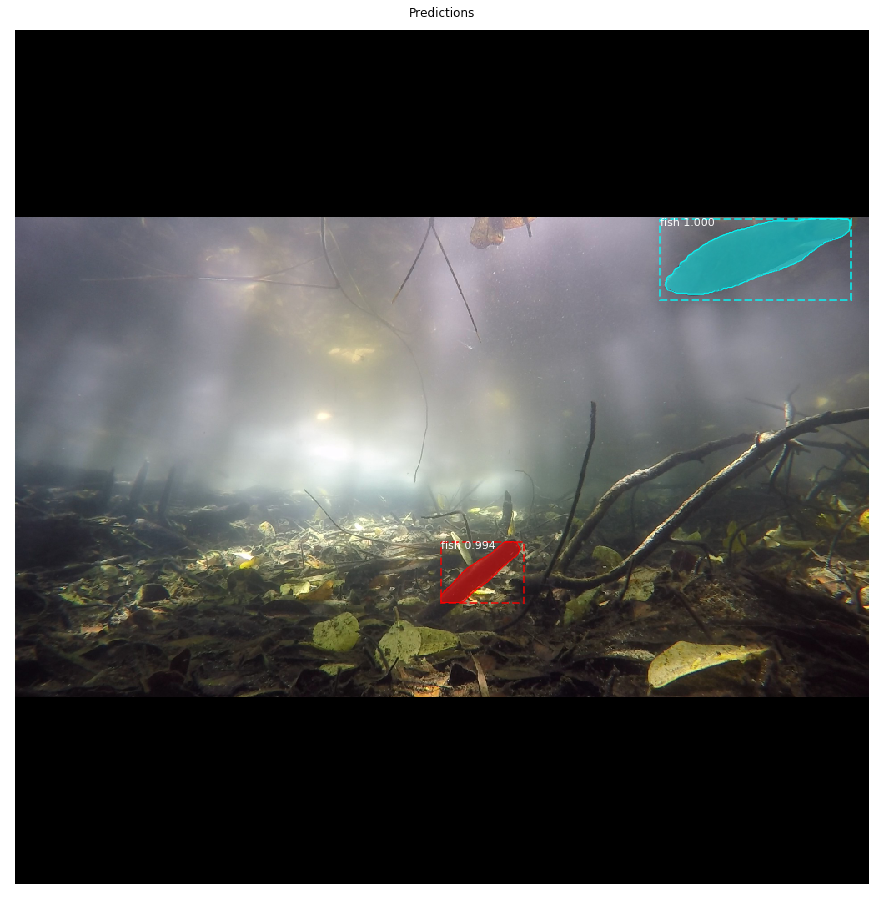

In [128]:
image_id = 8 #random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id,use_mini_mask = False)

info = dataset.image_info[image_id]
print("Image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose = 1)

# Display results
ax = get_ax(1)
r = results[0]
ap, precision , recall = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'], iou_thresholds=np.arange(0.9, 0.95, 0.5),
            verbose=0)
ax = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                           dataset.class_names, r['scores'], ax = ax,
                           title = "Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print(precision, recall)

In [129]:
#ax.figure.savefig('Bonito.jpg')

image ID: fish.GOPR0077_11_20.jpg (8) /media/iimas-doc/Seagate Backup Plus Drive/Dataset_Thesis/Dia/Video_sin_reflejo/GOPR0077_11_20.jpg
Original image shape:  [1080 1920    3]
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  225.00000  max: 1014.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.50-0.70:	 1.000


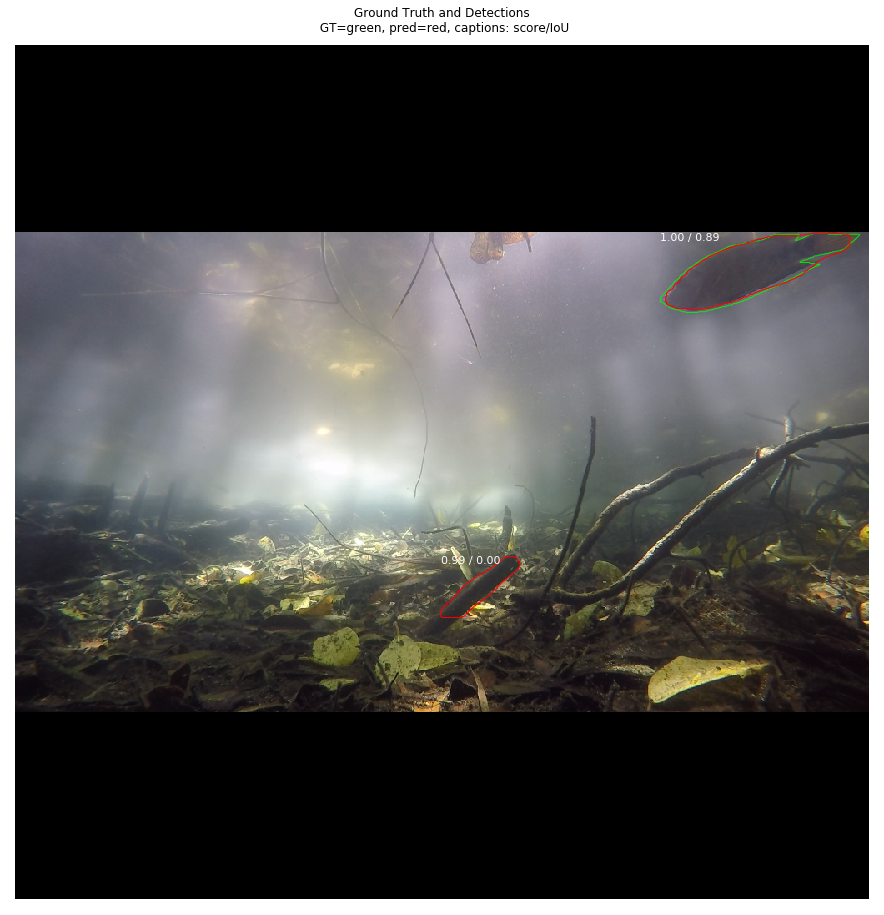

In [130]:
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
#results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'], iou_thresholds=np.arange(0.5,0.75,0.05),
                       verbose=1)


ax = visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

In [44]:
#mAP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.5)

In [108]:
np.array([0.5]).shape

(1,)

In [21]:
ax.figure.savefig('Bonish.jpg')

In [44]:
recalls[-2], precisions[-2], mAP

(0.8333333134651184, 1.0, 0.8333333134651184)

In [45]:
indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
mean_AP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])
indices, mean_AP

(array([1, 2, 3, 4, 5, 6]), 0.8333333134651184)

image_id:  116 /media/iimas-doc/Seagate Backup Plus Drive/Dataset_Thesis/Dia/Video_sin_reflejo/GOPR6800_5_45.jpg
original shape: (1080, 1920, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (3, 4)                min:  234.00000  max: 1005.00000  int32


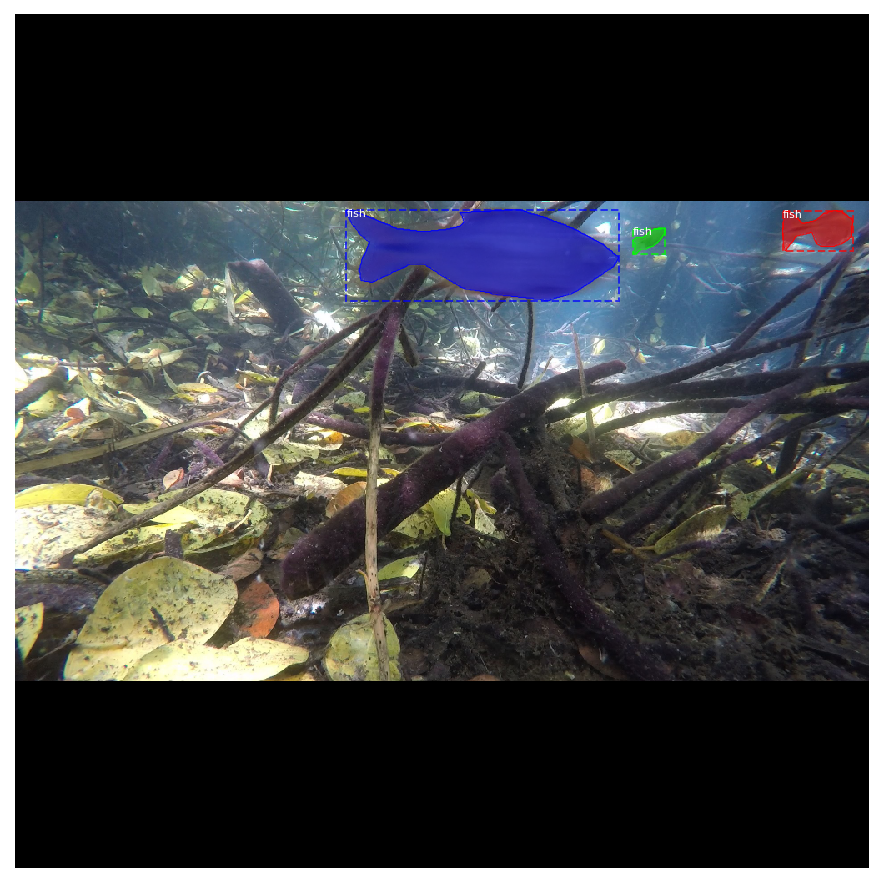

In [27]:
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
#Resize
image, windoe, scale, padding, _ =utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

#Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("original shape:", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
#Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


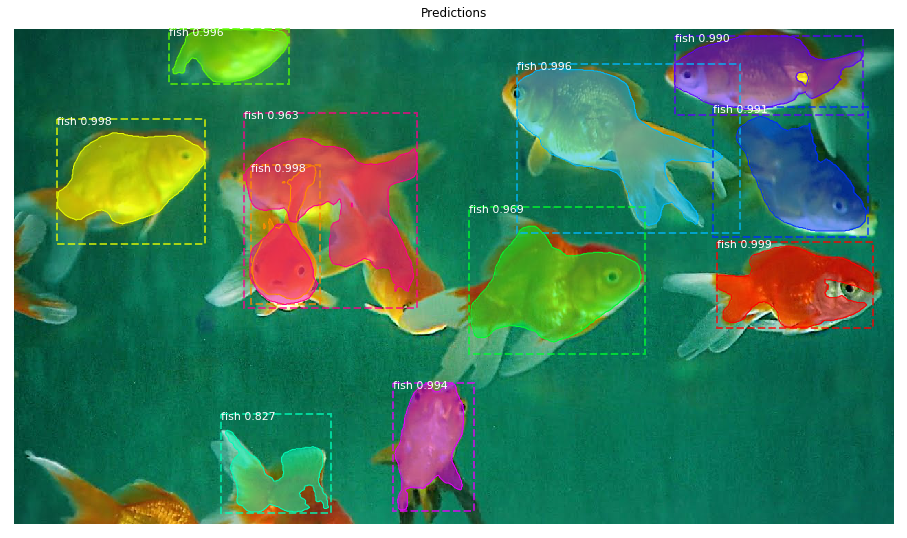

In [28]:
import matplotlib.image as mpimg
img = mpimg.imread('/media/iimas-doc/Seagate Backup Plus Drive/Dataset_Thesis/Internet_Images/7.jpg')
# Run object detection
results = model.detect([img], verbose = 1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
                           dataset.class_names, r['scores'], ax = ax,
                           title = "Predictions")

In [104]:
import skimage.draw
img = skimage.io.imread("/home/iimas-doc/Escritorio/out_Db/GOPR0010_2_45.jpg")

# Color splash

This is for illustration. You can call `fish.py` with the `splash` option to get better images without the black padding.

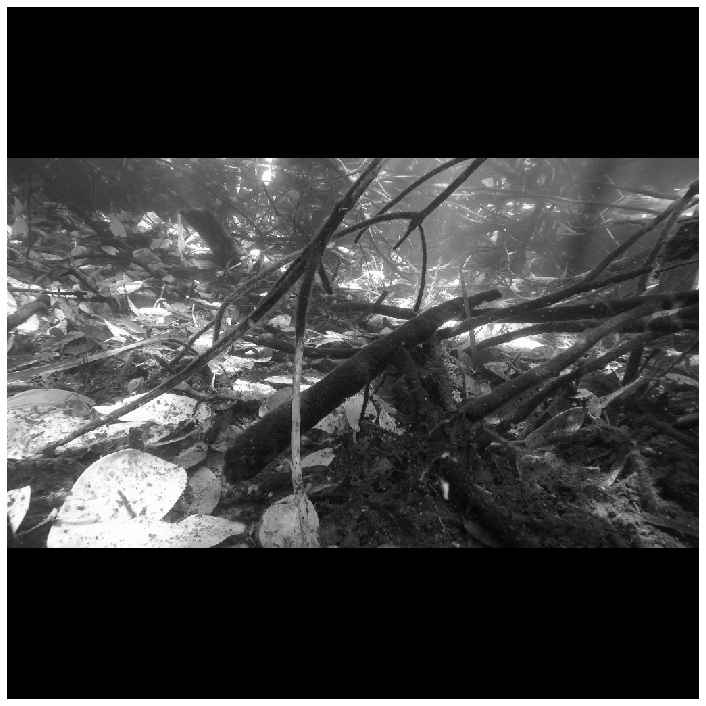

In [105]:
splash = fishvsall.color_splash(image, r['masks'])
display_images([splash], cols = 1)